In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


#### Power Conference Feature

From EDA we know that a small number of conferences account for 70% of all conference wins. 

If one of the two teams is in a power conference, indicate the advantage that team has for winning the game.

In [2]:
# Compare the conferences of two teams playing in a game.
# If both teams are in power conference or both teams are not in a power conference return 0.
# If the opponent team is in a power conference and the first team is not in a power conference return -1
# If the first team is a power conference team and opponent is not then return 1.

def conf_compare(team_conf, opp_conf):
    team_top = team_conf in top_tournament_conferences_list
    opp_top = opp_conf in top_tournament_conferences_list
    if team_top == opp_top:
        return 0
    elif team_top :
        return 1
    else:
        return -1

In [3]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: abs(kv[1]))

    return feature_importances_sorted


In [4]:
def display_important_features_rf_forest(classifier, features):
    importances = classifier.feature_importances_
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Coefficient Values')
    for items in feature_importances:
        print(items[0]," ", items[1])

In [5]:
def get_tournament_record(df, season, round_, team):
    return df[(df['season_t'] == season) & (df['round']== round_) & (df['team']==team)]


In [6]:
def print_game_info(df, season, round_, team):
    t_rec = get_tournament_record(df, season, round_, team)
    opp_team = t_rec['opp_team'].iloc[0]
    print('\t\t',team,'\t',opp_team)
    print('Seed','\t\t',"%6d"%t_rec['team_seed'].iloc[0],'\t',"%6d"%t_rec['opp_team_seed'].iloc[0])
    print('PPG','\t\t',"%6.2f"%t_rec['pts_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['pts_avg_o'].iloc[0])
    print('Allow PPG','\t',"%6.2f"%t_rec['opp_pts_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['opp_pts_avg_o'].iloc[0])
    print('Poss Avg','\t',"%6.2f"%t_rec['poss_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['poss_avg_o'].iloc[0])
    print('FG %','\t\t',"%6.2f"%(100*t_rec['fg_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['fg_pct_o'].iloc[0]))
    print('Allow FG %','\t',"%6.2f"%(100*t_rec['allow_fg_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['allow_fg_pct_o'].iloc[0]))
    print('Off Rb Avg','\t',"%6.2f"%t_rec['off_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['off_rebs_avg_o'].iloc[0])
    print('Allow Off Rb Avg',"%6.2f"%t_rec['allow_off_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_off_rebs_avg_o'].iloc[0])
    print('Def Rb Avg','\t',"%6.2f"%t_rec['def_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['def_rebs_avg_o'].iloc[0])
    print('Allow Def Rb Avg',"%6.2f"%t_rec['allow_def_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_def_rebs_avg_o'].iloc[0])  
    print('FT ATT Avg','\t',"%6.2f"%t_rec['ft_att_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['ft_att_avg_o'].iloc[0]) 
    print('Allow FT ATT Avg',"%6.2f"%t_rec['allow_ft_att_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_ft_att_avg_o'].iloc[0])
    print('FT %','\t\t',"%6.2f"%(100*t_rec['ft_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['ft_pct_o'].iloc[0]))
    print('Turnover Avg','\t',"%6.2f"%t_rec['to_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['to_avg_o'].iloc[0])
    print('Takeaway Avg','\t',"%6.2f"%t_rec['steal_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['steal_avg_o'].iloc[0])
    print('Win %','\t\t',"%6.2f"%(100*t_rec['win_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['win_pct_o'].iloc[0]))
    print('Off Rating','\t',"%6.2f"%t_rec['off_rating_t'].iloc[0],'\t',"%6.2f"%t_rec['off_rating_o'].iloc[0])
    print('\n\nTop Conference= ', t_rec['top_conf'].iloc[0])
    print('Game Result= ', t_rec['game_result'].iloc[0], ' (One indicates win for ', team,')')
    print('Predicted Result= ', t_rec['predicted_result'].iloc[0])
    print('Predicted Probability= ',"%6.3f"%t_rec['pred_win_prob'].iloc[0])
    return

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [7]:
#Note season indicates start of season, e.g. 2013 to 2014, the corresponding tournament season is 1 greater than this value
# The tournament season for season 2013 is 2014
summary_data = pd.read_csv('sr_summaries_kaggle_id.csv')
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(2773, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
38,2009,Centenary (LA),NaN,29,-17.16,-5.08,0.276,70,80,0.416,0.49,0.733,25,80.641379,9,11,20,27,15,7,86.804071,21


In [8]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(2772, 22)


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [9]:
# Read table of team names and associated team meta data
teams = pd.read_csv('D1_teams.csv')
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [10]:
tourney_data = pd.read_csv('tournament_results.csv')
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


### Extract some historical data

In [11]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [12]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

In [13]:
tourney_data.describe()['season']

count    2117.000000
mean     2001.193198
std         9.563883
min      1985.000000
25%      1993.000000
50%      2001.000000
75%      2010.000000
max      2017.000000
Name: season, dtype: float64

Note the tournament data is available for tournament years 1985 through 2017.

In [14]:
summary_data.describe()['season']

count    2772.00000
mean     2012.53355
std         2.28420
min      2009.00000
25%      2011.00000
50%      2013.00000
75%      2015.00000
max      2016.00000
Name: season, dtype: float64

The summary season data in this set goes back to 2010. 

So the intersection of season summary data with tournament data are regular seasons 2010 through 2016.

In [15]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [16]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 10 to 2104
Data columns (total 9 columns):
season          533 non-null int64
round           533 non-null int64
game_date       533 non-null object
win_seed        533 non-null int64
win_market      533 non-null object
win_team_id     533 non-null object
lose_seed       533 non-null int64
lose_market     533 non-null object
lose_team_id    533 non-null object
dtypes: int64(4), object(5)
memory usage: 41.6+ KB


In [17]:
tourney_data.head()

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952


In [18]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,1,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,1,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,1,2010
31,2011,16,2011-03-25,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,1,2010
33,2011,32,2011-03-20,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,1,2010
34,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2010
35,2011,68,2011-03-16,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,1,2010
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,2015


In [19]:
# We need to recode the game data so that we have representation of the losing game result class.
# Swap the team and opp team data on the odd rows and reverse the sense of the game result.

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.head()

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
10,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010
27,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011
30,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010


In [20]:

tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
#tourney_data.info()

In [21]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))
#tourney_data.info()

In [22]:
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20


Incorporate additional features here.
Team conference, seeding deltas.

In [23]:
tourney_data = tourney_data.join(teams, on='team_id_t', how='left')


In [24]:
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [25]:
print(top_tournament_conferences_list)
tourney_data['top_conf'] = tourney_data.apply(lambda row: conf_compare(row.conf_name_t, row.conf_name_o),axis=1)
tourney_data.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,0,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,0,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,0,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,0,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,0,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [26]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_data['upset_seed_threshold'] = tourney_data.apply(lambda row: abs(row.team_seed - row.opp_team_seed) > 6, axis=1).astype(int)
tourney_data.head()


,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,1,1


### Opponent Plots

In [42]:
tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})

In [43]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 0 to 532
Data columns (total 58 columns):
season_t                533 non-null int64
round                   533 non-null int64
game_date               533 non-null object
team_seed               533 non-null int64
team                    533 non-null object
team_id_t               533 non-null object
opp_team_seed           533 non-null int64
opp_team                533 non-null object
opp_team_id             533 non-null object
game_result             533 non-null int32
start_season            533 non-null int64
School_t                533 non-null object
Games_t                 533 non-null int64
SRS_t                   533 non-null float64
SOS_t                   533 non-null float64
win_pct_t               533 non-null float64
pts_avg_t               533 non-null int64
opp_pts_avg_t           533 non-null int64
fg_pct_t                533 non-null float64
allow_fg_pct_t          533 non-null float64
ft_pct_t           

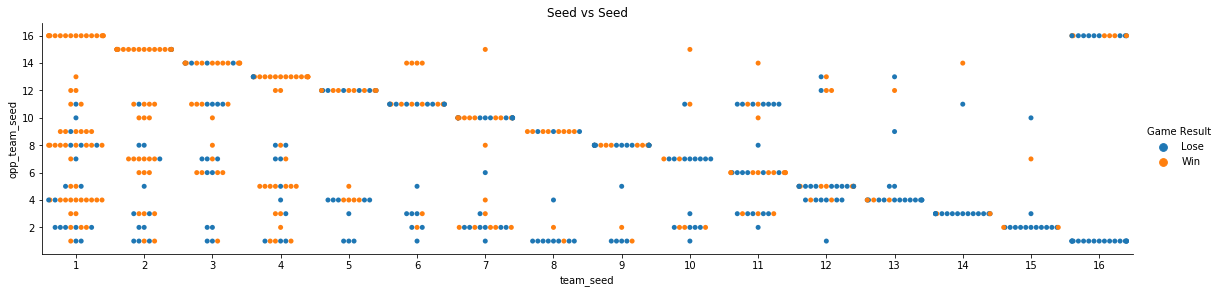

In [86]:
g = sns.catplot(x="team_seed", y="opp_team_seed", hue="Game Result", 
                height=4, aspect=4,data=tourney_data,kind='swarm')
plt.title('Seed vs Seed')
plt.show()

In [92]:
tourney_data[(tourney_data['team_seed']==16) & (tourney_data['opp_team_seed']==16) ]

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,top_conf,upset_seed_threshold,Game Result
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,0,2012,Long Island University,34,-3.21,-5.80,0.588,78,76,0.479,0.468,0.691,19,80.676471,11,11,19,21,14,6,96.682464,25,2012,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,36,-1.73,-2.28,0.583,65,64,0.421,0.428,0.699,20,72.988889,10,10,19,24,11,7,89.054651,19,Northeast,Colonial,0,0,Lose
50,2013,68,2013-03-19,16,Liberty,559db90c-741f-40d1-aa81-3fdd1d4889f3,16,North Carolina A&T,53aaac6a-796e-41a6-a04e-6ce74c5717f8,0,2012,Liberty,36,-9.13,-5.80,0.417,69,69,0.429,0.422,0.730,22,76.111111,10,12,22,24,13,5,90.656934,21,2012,North Carolina A&T,53aaac6a-796e-41a6-a04e-6ce74c5717f8,37,-6.94,-6.30,0.541,62,61,0.403,0.388,0.658,21,76.070270,10,12,21,24,15,7,81.503588,21,Big South,Mid Eastern Athletic,0,0,Lose
51,2017,68,2017-03-15,16,UC Davis,8aaad1c0-d16e-4b9f-8541-dac670addd71,16,North Carolina Central,e4c315a0-e83f-4d14-856e-34a0463059e3,1,2016,UC-Davis,36,-5.21,-4.68,0.639,70,69,0.435,0.426,0.674,18,79.227778,10,9,25,24,14,5,88.352850,23,2016,North Carolina Central,e4c315a0-e83f-4d14-856e-34a0463059e3,34,-3.18,-12.12,0.735,74,63,0.454,0.393,0.683,16,78.958824,11,12,26,23,11,6,93.719735,20,Big West,Mid Eastern Athletic,0,0,Win
68,2016,68,2016-03-15,16,Fairleigh Dickinson,b71d5a1b-2671-4e5a-b94b-06bfb22a27dd,16,Florida Gulf Coast,5326c079-3dc3-468f-a601-b776dd9c1e62,0,2015,Fairleigh Dickinson,33,-10.90,-8.31,0.545,77,78,0.458,0.457,0.697,26,82.339394,10,12,23,26,12,7,93.515383,20,2015,Florida Gulf Coast,5326c079-3dc3-468f-a601-b776dd9c1e62,35,-0.79,-3.82,0.600,77,70,0.479,0.412,0.644,20,81.577143,11,11,28,24,12,6,94.389185,22,Northeast,Atlantic Sun,0,0,Lose
163,2015,68,2015-03-17,16,Hampton,161354af-1f3e-4d58-88f7-e016ec74b7b6,16,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502,1,2014,Hampton,35,-8.25,-7.08,0.486,67,68,0.406,0.413,0.652,25,79.902857,11,11,25,25,14,6,83.851820,24,2014,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502,33,-1.34,-3.34,0.576,69,67,0.432,0.437,0.691,26,77.593939,10,10,21,23,14,8,88.924471,25,Mid Eastern Athletic,Metro Atlantic Athletic,0,0,Win
226,2011,68,2011-03-15,16,Arkansas-Little Rock,0dadedb0-2bd3-45e7-91a3-93af6c4e87f2,16,UNC Asheville,ad9fce12-6b1a-400c-bcbe-29d84d065fc0,0,2010,Little Rock,36,-4.32,-2.97,0.528,68,67,0.426,0.420,0.690,22,74.822222,10,10,22,25,11,5,90.882091,22,2010,North Carolina-Asheville,ad9fce12-6b1a-400c-bcbe-29d84d065fc0,34,-0.69,-2.89,0.588,73,68,0.452,0.444,0.711,20,81.764706,11,12,23,21,14,9,89.280576,23,Sun Belt,Big South,0,0,Lose
264,2014,68,2014-03-19,16,Texas Southern,eb157f98-0697-459c-9293-ddb162ceb28b,16,Cal Poly,45439cdb-af7a-4743-936c-dccc76b30877,0,2013,Texas Southern,34,-8.41,-10.07,0.559,76,73,0.462,0.451,0.718,17,78.588235,11,11,25,22,13,4,96.706587,26,2013,Cal Poly,45439cdb-af7a-4743-936c-dccc76b30877,34,-1.34,1.69,0.412,62,63,0.408,0.434,0.688,20,70.417647,11,10,21,23,8,5,88.046111,17,Southwestern Athletic,Big West,0,0,Lose
390,2015,68,2015-03-18,16,North Florida,09920a5f-1b25-466c-b5ae-6167214f5ba9,16,Robert Morris,6906e22d-92fa-40cb-8c05-ec8391ac1979,0,2014,North Florida,35,-0.82,-5.94,0.657,75,68,0.470,0.432,0.723,19,75.565714,9,11,25,22,12,6,99.251361,21,2014,Robert Morris,6906e22d-92fa-40cb-8c05-ec8391ac1979,35,-3.02,-3.50,0.571,68,68,0.443,0.431,0.709,20,76.1

### Upset Plots

##### High Stats

In [158]:
total_games =0
tournament_games = {}
for year in range(2003,2018,1):
    tournament_games[year] = tourney_data[tourney_data['season_t'] == year].shape[0]
    total_games += tournament_games[year]
    
print('total games= ', total_games)

total games=  533


In [95]:
def compute_percentage(x):
    #print(x)
    game_count = tournament_games[x[0]]
    #set_trace()
    val = 100.0 * len(x)/ game_count
    
    return val


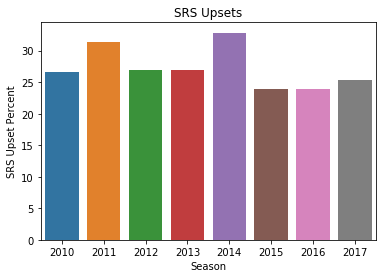

Total upsets=  145
Average upsets = 27.205%


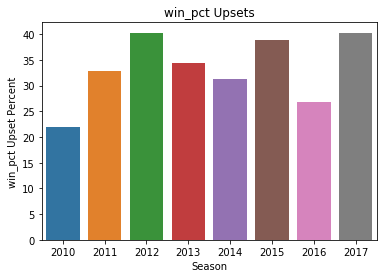

Total upsets=  178
Average upsets = 33.396%


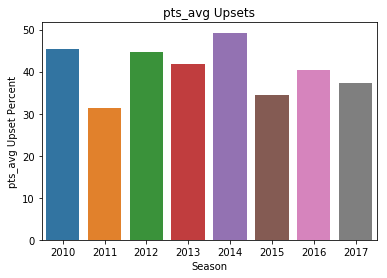

Total upsets=  216
Average upsets = 40.525%


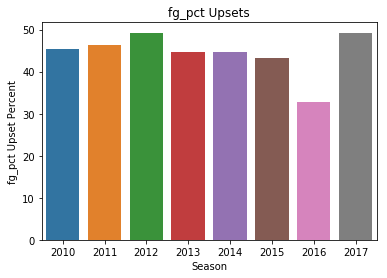

Total upsets=  237
Average upsets = 44.465%


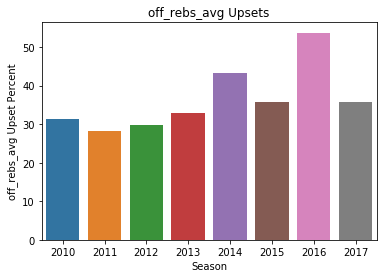

Total upsets=  194
Average upsets = 36.398%


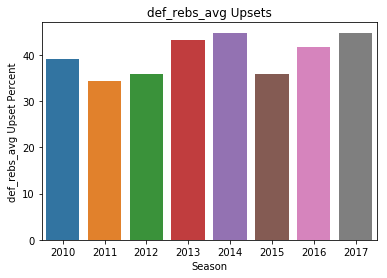

Total upsets=  213
Average upsets = 39.962%


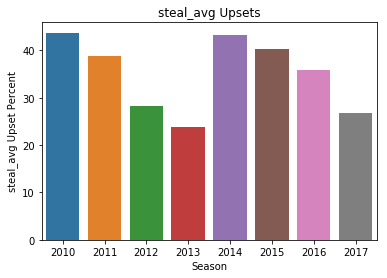

Total upsets=  187
Average upsets = 35.084%


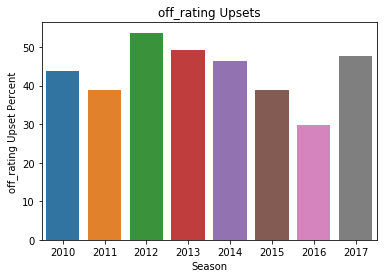

Total upsets=  232
Average upsets = 43.527%


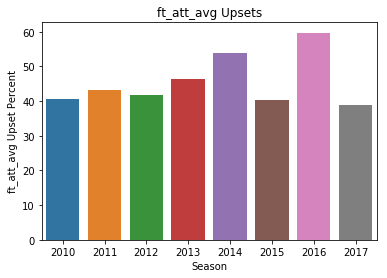

Total upsets=  243
Average upsets = 45.591%


In [159]:
ratings_dict={}
high_stats = ['SRS','win_pct','pts_avg','fg_pct','off_rebs_avg','def_rebs_avg','steal_avg','off_rating','ft_att_avg']
#high_stats = ['off_rating']
for stat in high_stats:
    stat_t = stat + '_t'
    stat_o = stat + '_o'
    upset_cond_1 = (tourney_data['game_result'] == 0) & (tourney_data[stat_t] > tourney_data[stat_o])
    upset_cond_2 = (tourney_data['game_result'] == 1) & (tourney_data[stat_t] < tourney_data[stat_o])
    upsets = tourney_data[upset_cond_1 | upset_cond_2][['season_t', 'team','team_seed','opp_team',
                                                        'opp_team_seed','game_result',stat_t , stat_o ]]
    plot = sns.barplot(x='season_t', y='season_t',data=upsets, orient='v',estimator=lambda x: compute_percentage(x))
    plot.set(xlabel='Season', ylabel=stat +' Upset Percent')
    plot.set_title(stat + " Upsets")
    plt.show()
    print("Total upsets= ", upsets.shape[0])
    avg_upsets = upsets.shape[0]*100/total_games
    print("Average upsets = {:.3f}%".format(avg_upsets))
    ratings_dict[stat] = avg_upsets


##### Low Stats

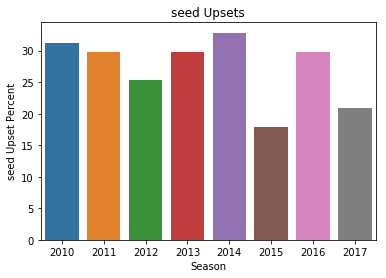

Average upsets = 27.205%


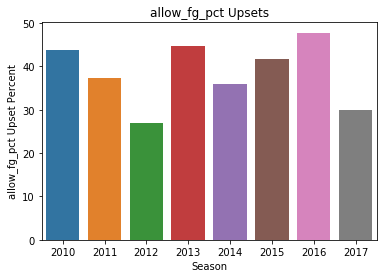

Average upsets = 38.462%


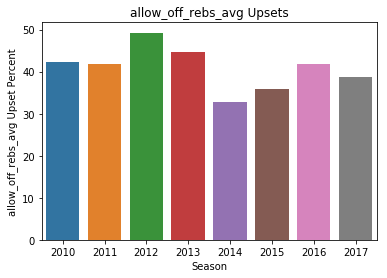

Average upsets = 40.901%


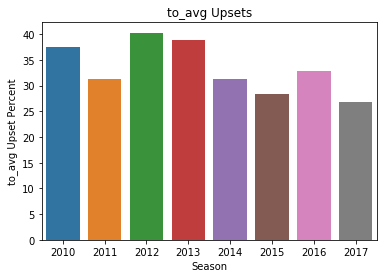

Average upsets = 33.396%


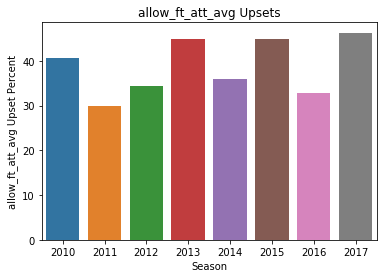

Average upsets = 38.649%


In [162]:
tourney_data['seed_t'] = tourney_data['team_seed']
tourney_data['seed_o'] = tourney_data['opp_team_seed']
low_stats = ['seed','allow_fg_pct','allow_off_rebs_avg','to_avg','allow_ft_att_avg']
#high_stats = ['off_rating']
for stat in low_stats:
    stat_t = stat + '_t'
    stat_o = stat + '_o'
    upset_cond_1 = (tourney_data['game_result'] == 0) & (tourney_data[stat_t] < tourney_data[stat_o])
    upset_cond_2 = (tourney_data['game_result'] == 1) & (tourney_data[stat_t] > tourney_data[stat_o])
    upsets = tourney_data[upset_cond_1 | upset_cond_2][['season_t', 'team','team_seed','opp_team',
                                                        'opp_team_seed','game_result',stat_t , stat_o ]]
    plot = sns.barplot(x='season_t', y='season_t',data=upsets, orient='v',estimator=lambda x: compute_percentage(x))
    plot.set(xlabel='Season', ylabel=stat +' Upset Percent')
    plot.set_title(stat + " Upsets")
    plt.show()
    avg_upsets = upsets.shape[0]*100/total_games
    print("Average upsets = {:.3f}%".format(avg_upsets))
    ratings_dict[stat] = avg_upsets

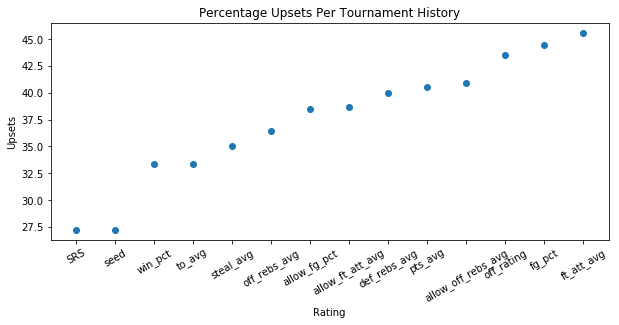

In [163]:
sorted_ratings = sorted(ratings_dict.items(), key=operator.itemgetter(1))
sorted_ratings
g= plt.scatter(*zip(*sorted_ratings))
plt.title('Percentage Upsets Per Tournament History')
plt.xlabel('Rating')
plt.ylabel('Upsets')
plt.xticks(rotation=30)
g.figure.set_size_inches(10,4)
plt.show()